In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2018)

from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

import xgboost as xgb
import lightgbm as lgb

import pickle

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r"compiletime version 3.5 of module '_catboost' does not match runtime version 3.6")

    import catboost as ctb
    
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

## Data

In [4]:
train = pd.read_hdf('../data/train.car_price.h5')
test = pd.read_hdf('../data/test.car_price.h5') #zbiór testowy bez odpowiedzi

In [5]:
train.shape

(106494, 155)

## Newest Version

In [6]:
def combine(value1, value2):
    if str(value1) == 'None':
        return value2
    else:
        return value1

In [7]:
#numeric
print(len(train.loc[(train['param_year'].notnull())&(train['param_rok-produkcji'].notnull())]))
print(len(train.loc[(train['param_engine-power'].notnull())&(train['param_moc'].notnull())]))
print(len(train.loc[(train['param_engine-capacity'].notnull())&(train['param_pojemność-skokowa'].notnull())]))
print(len(train.loc[(train['param_mileage'].notnull())&(train['param_przebieg'].notnull())]))
print(len(train.loc[(train['param_nr-of-seats'].notnull())&(train['param_liczba-miejsc'].notnull())]))
print(len(train.loc[(train['param_door-count'].notnull())&(train['param_liczba-drzwi'].notnull())]))

#categorical
print(len(train.loc[(train['param_no-accident'].notnull())&(train['param_bezwypadkowy'].notnull())]))
print(len(train.loc[(train['param_damaged'].notnull())&(train['param_uszkodzony'].notnull())]))
print(len(train.loc[(train['param_color'].notnull())&(train['param_kolor'].notnull())]))
print(len(train.loc[(train['param_metallic'].notnull())&(train['param_metalik'].notnull())]))
print(len(train.loc[(train['param_acrylic'].notnull())&(train['param_akryl-(niemetalizowany)'].notnull())]))
print(len(train.loc[(train['param_pearl'].notnull())&(train['param_perłowy'].notnull())]))
print(len(train.loc[(train['param_original-owner'].notnull())&(train['param_pierwszy-właściciel'].notnull())]))
print(len(train.loc[(train['param_gearbox'].notnull())&(train['param_skrzynia-biegów'].notnull())]))
print(len(train.loc[(train['param_transmission'].notnull())&(train['param_napęd'].notnull())]))
print(len(train.loc[(train['param_body-type'].notnull())&(train['param_typ'].notnull())]))
print(len(train.loc[(train['param_make'].notnull())&(train['param_marka-pojazdu'].notnull())]))
print(len(train.loc[(train['param_model'].notnull())&(train['param_model-pojazdu'].notnull())]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [8]:
train_combine = train[['price_value', 'car_id', 'param_stan', 'seller_type', 'param_kategoria']].copy()

# Numeric
train_combine['year'] = train[['param_year', 'param_rok-produkcji',]].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['power'] = train[['param_engine-power','param_moc']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['engine'] = train[['param_engine-capacity','param_pojemność-skokowa']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['mileage'] = train[['param_mileage','param_przebieg']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['seats'] = train[['param_nr-of-seats','param_liczba-miejsc']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['doors'] = train[['param_door-count','param_liczba-drzwi']].apply(lambda x: combine(x[0], x[1]), axis = 1)

# categorical
train_combine['no_accident'] = train[['param_no-accident','param_bezwypadkowy']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['damaged'] = train[['param_damaged','param_uszkodzony']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['color'] = train[['param_color','param_kolor']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['metallic'] = train[['param_metallic','param_metalik']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['acrylic'] = train[['param_acrylic','param_akryl-(niemetalizowany)']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['pearl'] = train[['param_pearl','param_perłowy']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['owner'] = train[['param_original-owner','param_pierwszy-właściciel']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['gears'] = train[['param_gearbox','param_skrzynia-biegów']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['trans'] = train[['param_transmission','param_napęd']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['type'] = train[['param_body-type','param_typ']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['make'] = train[['param_make','param_marka-pojazdu']].apply(lambda x: combine(x[0], x[1]), axis = 1)
train_combine['model'] = train[['param_model','param_model-pojazdu']].apply(lambda x: combine(x[0], x[1]), axis = 1)

type_list = train_combine['type'].value_counts().index[:9]
make_list = train_combine['make'].value_counts()[:30]
model_list = train_combine['model'].value_counts()[:100]


train_combine['type_reduced'] = train_combine['type'].apply(lambda x: x if x in type_list else 'other')
train_combine['make_reduced'] = train_combine['make'].apply(lambda x: x if x in make_list else 'other')
train_combine['model_reduced'] = train_combine['model'].apply(lambda x: x if x in model_list else 'other')

train_combine.sample(5)

,price_value,car_id,param_stan,seller_type,param_kategoria,year,power,engine,mileage,seats,...,pearl,owner,gears,trans,type,make,model,type_reduced,make_reduced,model_reduced
139806,24900.0,139806,Używane,Dealer,Osobowe,2010,105 KM,1 598 cm3,157 000 km,5,...,Tak,None,Manualna,Na przednie koła,Kombi,Škoda,Octavia,Kombi,Škoda,Octavia
14109,13900.0,14109,Używane,Osoba prywatna,Osobowe,2005,136 KM,1 997 cm3,255 500 km,5,...,None,Tak,Manualna,Na przednie koła,Kombi,Volvo,V50,Kombi,Volvo,V50
98911,14900.0,98911,Używane,Dealer,Osobowe,2007,115 KM,1 800 cm3,179 000 km,5,...,None,None,Manualna,Na przednie koła,Minivan,Ford,C-MAX,Minivan,Ford,C-MAX
55495,97900.0,55495,Używane,Dealer,Osobowe,2016,150 KM,1 968 cm3,37 477 km,5,...,None,Tak,"Automatyczna dwusprzęgłowa (DCT, DSG)",Na przednie koła,Sedan,Volkswagen,Passat,Sedan,Volkswagen,Passat
109016,13200.0,109016,Używane,Osoba prywatna,Osobowe,2003,170 KM,2 200 cm3,274 000 km,5,...,None,None,Manualna,Na tylne koła,Sedan,BMW,Seria 5,Sedan,BMW,Seria 5


In [9]:
train_combine.isnull().sum()

price_value             0
car_id                  0
param_stan            109
seller_type           109
param_kategoria       109
year                  109
power                9410
engine               5026
mileage               355
seats               11839
doors                9826
no_accident         39723
damaged            102240
color                 109
metallic            33900
acrylic            102314
pearl               94998
owner               59340
gears                5741
trans               16341
type                  110
make                  109
model                 109
type_reduced            0
make_reduced            0
model_reduced           0
dtype: int64

In [10]:
train_combine['year_num']     = train_combine['year'].apply(lambda x: -1 if x is None else int(x))
train_combine['power_num']    = train_combine['power'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
train_combine['engine_num']   = train_combine['engine'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
train_combine['mileage_num']  = train_combine['mileage'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
train_combine['seats_num']     = train_combine['seats'].apply(lambda x: -1 if x is None else int(x))
train_combine['doors_num']     = train_combine['doors'].apply(lambda x: -1 if x is None else int(x))

train_combine['power_cap_num']= (train_combine['engine_num']/10) + train_combine['power_num']
train_combine['power_cap_num_log']= train_combine['power_cap_num'].apply(lambda x: -1 if x<=0 else np.log(x+1))
train_combine['num_feats'] = train.select_dtypes(include=bool).sum(axis=1)
train_combine['year_rev_log'] = np.log(2020 - train_combine['year_num'])

train_combine.sample(5)

,price_value,car_id,param_stan,seller_type,param_kategoria,year,power,engine,mileage,seats,...,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,year_rev_log
15345,83900.0,15345,Nowe,Dealer,Osobowe,2017,130 KM,1 197 cm3,10 km,5,...,2017,130,1197,10,5,5,249.7,5.524257,25,1.098612
51899,194900.0,51899,Używane,Dealer,Osobowe,2017,170 KM,2 148 cm3,15 900 km,5,...,2017,170,2148,15900,5,4,384.8,5.955319,44,1.098612
43300,47300.0,43300,Używane,Dealer,Osobowe,2017,110 KM,1 000 cm3,7 km,5,...,2017,110,1000,7,5,5,210.0,5.351858,26,1.098612
92364,10900.0,92364,Używane,Dealer,Osobowe,2007,None,None,187 000 km,None,...,2007,-1,-1,187000,-1,-1,-1.1,-1.000000,16,2.564949
51064,19500.0,51064,Używane,Osoba prywatna,Osobowe,2011,115 KM,1 600 cm3,196 000 km,5,...,2011,115,1600,196000,5,5,275.0,5.620401,33,2.197225


In [11]:
train_feats = train.select_dtypes(include=bool)
train_feats.sample(5)

,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,...,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne
22097,False,False,True,True,False,True,True,True,True,True,...,False,True,True,False,True,False,False,True,True,True
79599,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,True,True,False,True,False,False
11559,False,False,False,False,False,False,True,True,True,True,...,False,False,True,False,False,False,False,False,False,False
84593,True,False,False,False,False,True,True,False,False,False,...,False,True,False,False,True,False,False,False,False,False
89429,False,False,False,False,False,False,True,True,True,True,...,False,True,True,False,False,True,False,False,False,False


In [12]:
train_combine['price_log'] = np.log(train_combine['price_value'])

In [13]:
train_combine.isnull().sum()

price_value               0
car_id                    0
param_stan              109
seller_type             109
param_kategoria         109
year                    109
power                  9410
engine                 5026
mileage                 355
seats                 11839
doors                  9826
no_accident           39723
damaged              102240
color                   109
metallic              33900
acrylic              102314
pearl                 94998
owner                 59340
gears                  5741
trans                 16341
type                    110
make                    109
model                   109
type_reduced              0
make_reduced              0
model_reduced             0
year_num                  0
power_num                 0
engine_num                0
mileage_num               0
seats_num                 0
doors_num                 0
power_cap_num             0
power_cap_num_log         0
num_feats                 0
year_rev_log        

In [14]:
train_features = train_combine.dropna(axis=1).drop(['type_reduced', 
                                                    'make_reduced', 
                                                    'model_reduced'
                                                   ], axis=1)
train_features.sample(5)

,price_value,car_id,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,year_rev_log,price_log
144937,26900.0,144937,2014,69,1000,141114,2,5,169.0,5.135798,20,1.791759,10.199882
135367,18500.0,135367,2005,136,1997,168690,5,4,335.7,5.819192,25,2.708050,9.825526
102838,195400.0,102838,2017,192,1998,5,5,5,391.8,5.973301,43,1.098612,12.182804
56163,6800.0,56163,2004,-1,-1,298399,-1,-1,-1.1,-1.000000,0,2.772589,8.824678
52801,19900.0,52801,2008,105,1900,96000,5,5,295.0,5.690359,21,2.484907,9.898475


<Figure size 432x288 with 0 Axes>

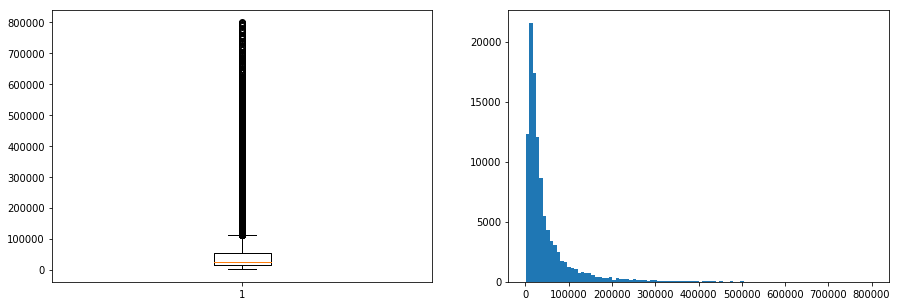

In [15]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['price_value'])
ax2.hist(train_features['price_value'], bins=100)
plt.show()

<Figure size 432x288 with 0 Axes>

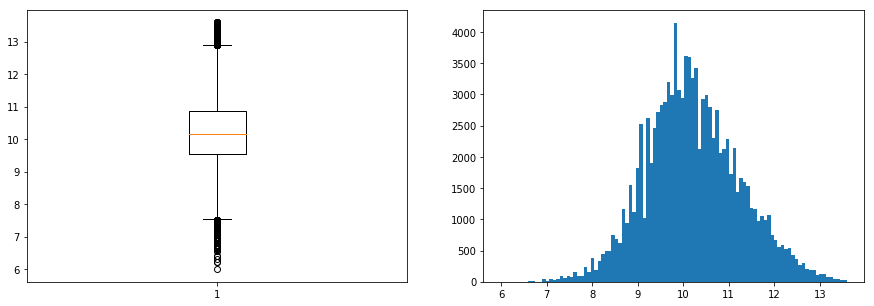

In [16]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['price_log'])
ax2.hist(train_features['price_log'], bins=100)
plt.show()

<Figure size 432x288 with 0 Axes>

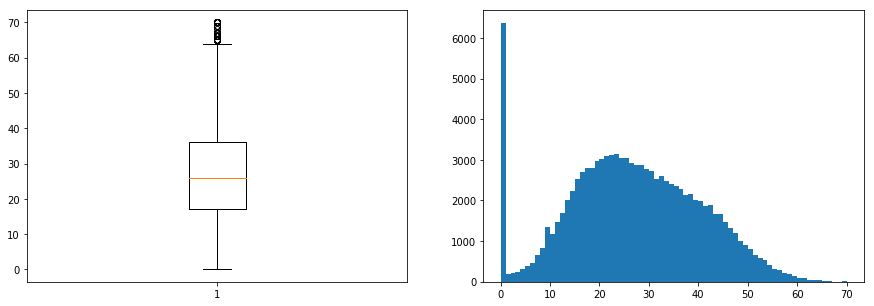

70


In [17]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['num_feats'])
ax2.hist(train_features['num_feats'], bins=70)
plt.show()
print(train_features['num_feats'].max())

<Figure size 432x288 with 0 Axes>

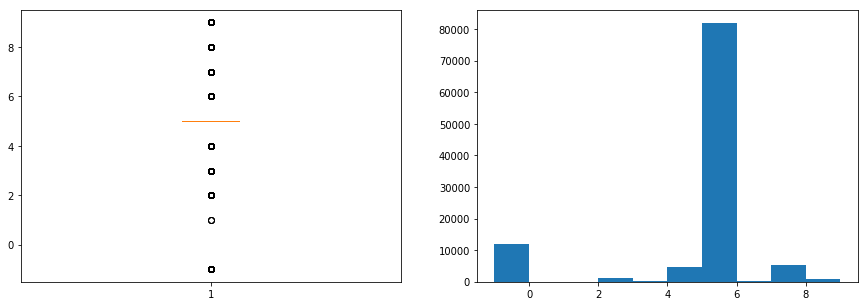

9


In [18]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['seats_num'])
ax2.hist(train_features['seats_num'], bins=10)
plt.show()
print(train_features['seats_num'].max())

<Figure size 432x288 with 0 Axes>

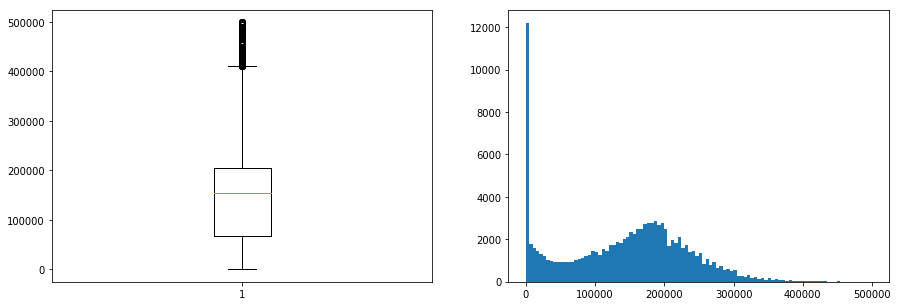

14600690


In [19]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['mileage_num'].loc[train_features['mileage_num']<500000])
ax2.hist(train_features['mileage_num'].loc[train_features['mileage_num']<500000], bins=100)
plt.show()
print(train_features['mileage_num'].max())

<Figure size 432x288 with 0 Axes>

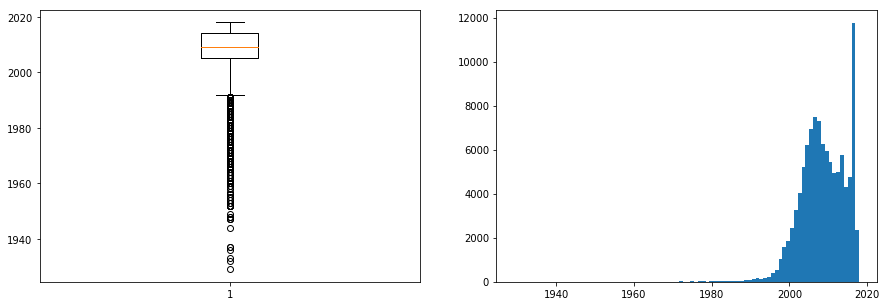

1929


In [20]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['year_num'].loc[train_features['year_num']>1900])
ax2.hist(train_features['year_num'].loc[train_features['year_num']>1900], bins=90)
plt.show()
print(train_features['year_num'].loc[train_features['year_num']>1900].min())

<Figure size 432x288 with 0 Axes>

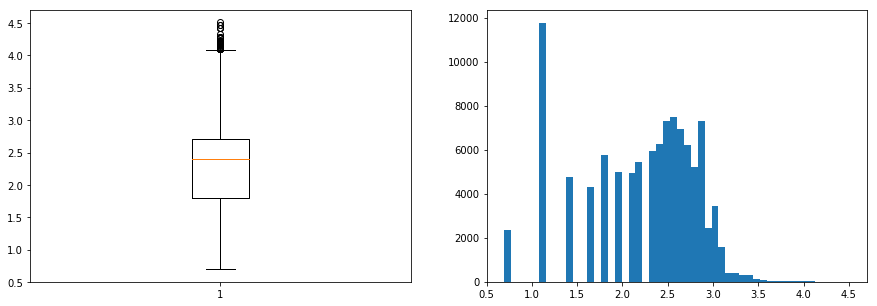

7.611347717403621


In [21]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['year_rev_log'].loc[train_features['year_rev_log']<7])
ax2.hist(train_features['year_rev_log'].loc[train_features['year_rev_log']<7], bins=50)
plt.show()
print(train_features['year_rev_log'].max())

<Figure size 432x288 with 0 Axes>

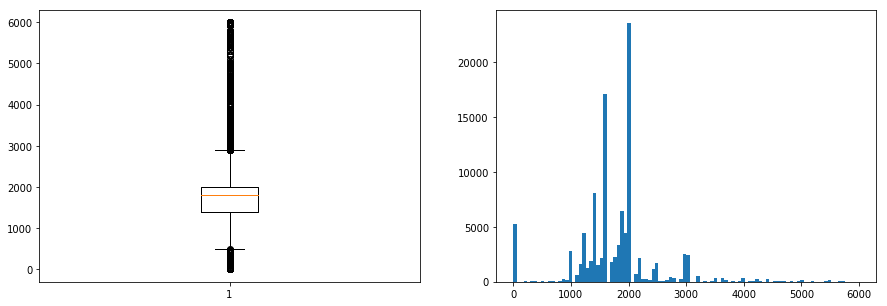

In [22]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['engine_num'].loc[train_features['engine_num']<6000])
ax2.hist(train_features['engine_num'].loc[train_features['engine_num']<6000], bins=100)
plt.show()

<Figure size 432x288 with 0 Axes>

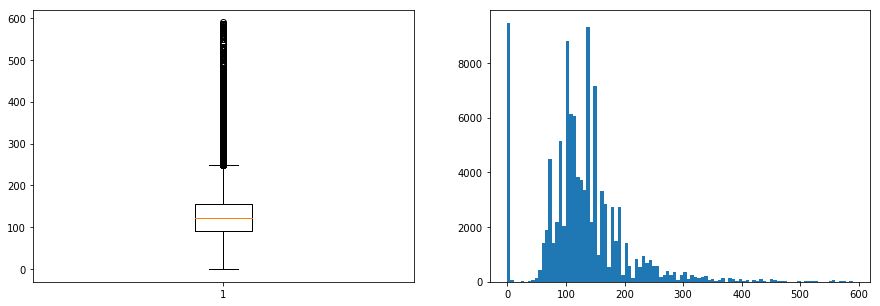

In [23]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['power_num'].loc[train_features['power_num']<600])
ax2.hist(train_features['power_num'].loc[train_features['power_num']<600], bins=100)
plt.show()

<Figure size 432x288 with 0 Axes>

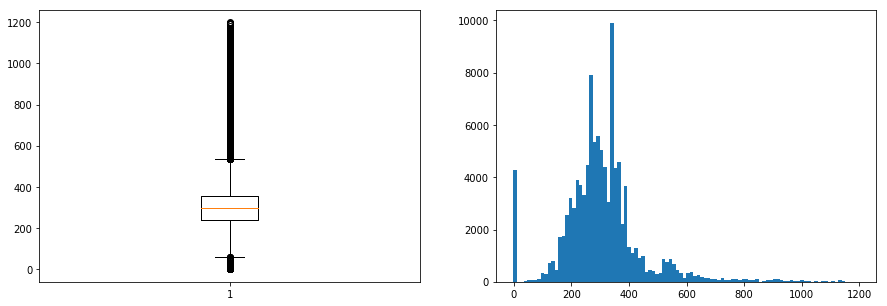

In [24]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['power_cap_num'].loc[train_features['power_cap_num']<1200])
ax2.hist(train_features['power_cap_num'].loc[train_features['power_cap_num']<1200], bins=100)
plt.show()

<Figure size 432x288 with 0 Axes>

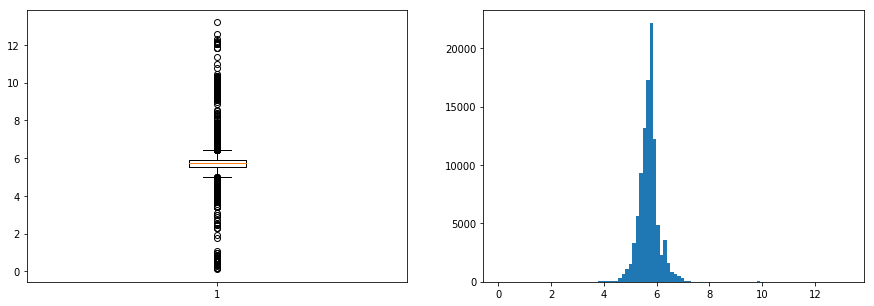

In [25]:
plt.figure()
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15, 5)) 
ax1.boxplot(train_features['power_cap_num_log'].loc[train_features['power_cap_num_log']>0])
ax2.hist(train_features['power_cap_num_log'].loc[train_features['power_cap_num_log']>0], bins=100)
plt.show()

In [26]:
train_combine.columns

Index(['price_value', 'car_id', 'param_stan', 'seller_type', 'param_kategoria',
       'year', 'power', 'engine', 'mileage', 'seats', 'doors', 'no_accident',
       'damaged', 'color', 'metallic', 'acrylic', 'pearl', 'owner', 'gears',
       'trans', 'type', 'make', 'model', 'type_reduced', 'make_reduced',
       'model_reduced', 'year_num', 'power_num', 'engine_num', 'mileage_num',
       'seats_num', 'doors_num', 'power_cap_num', 'power_cap_num_log',
       'num_feats', 'year_rev_log', 'price_log'],
      dtype='object')

In [27]:
ohe_train_df = (pd.get_dummies(train_combine[['no_accident', 
                                              'damaged',
                                              'color',
                                              'metallic',
                                              'acrylic',
                                              'pearl',
                                              'param_stan',
                                              'seller_type',
                                              'owner', 
                                              'gears',
                                              'trans', 
                                              'type_reduced',
                                              'make_reduced',
                                              'model_reduced'
                                             ]]))

ohe_train_df['special'] = (ohe_train_df['metallic_Tak'] + 
                           ohe_train_df['metallic_metallic'] + 
                           ohe_train_df['acrylic_Tak'] + 
                           ohe_train_df['acrylic_acrylic'] + 
                           ohe_train_df['pearl_Tak'])

ohe_train_df.sample(5)

,no_accident_Tak,damaged_Tak,color_Beżowy,color_Biały,color_Bordowy,color_Brązowy,color_Czarny,color_Czerwony,color_Fioletowy,color_Inny kolor,...,model_reduced_X1,model_reduced_X3,model_reduced_X5,model_reduced_XC 60,model_reduced_XC 90,model_reduced_Yaris,model_reduced_Zafira,model_reduced_i20,model_reduced_other,special
159180,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80029,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100892,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
57773,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
118119,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
list(ohe_train_df.columns)

['no_accident_Tak',
 'damaged_Tak',
 'color_Beżowy',
 'color_Biały',
 'color_Bordowy',
 'color_Brązowy',
 'color_Czarny',
 'color_Czerwony',
 'color_Fioletowy',
 'color_Inny kolor',
 'color_Niebieski',
 'color_Srebrny',
 'color_Szary',
 'color_Zielony',
 'color_Złoty',
 'color_Żółty',
 'metallic_Tak',
 'metallic_metallic',
 'acrylic_Tak',
 'acrylic_acrylic',
 'pearl_Tak',
 'param_stan_Nowe',
 'param_stan_Używane',
 'seller_type_Dealer',
 'seller_type_Osoba prywatna',
 'owner_Tak',
 'gears_Automatyczna bezstopniowa (CVT)',
 'gears_Automatyczna dwusprzęgłowa (DCT, DSG)',
 'gears_Automatyczna hydrauliczna (klasyczna)',
 'gears_Manualna',
 'gears_Półautomatyczna (ASG, Tiptronic)',
 'trans_4x4 (dołączany automatycznie)',
 'trans_4x4 (dołączany ręcznie)',
 'trans_4x4 (stały)',
 'trans_Na przednie koła',
 'trans_Na tylne koła',
 'type_reduced_Auta małe',
 'type_reduced_Auta miejskie',
 'type_reduced_Coupe',
 'type_reduced_Kabriolet',
 'type_reduced_Kombi',
 'type_reduced_Kompakt',
 'type_redu

In [29]:
train_data = (pd.concat([train_features, 
                         train_feats,
                         ohe_train_df], axis = 1)
                 .drop(['car_id'], axis=1))

train_data.sample(5)

,price_value,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,...,model_reduced_X1,model_reduced_X3,model_reduced_X5,model_reduced_XC 60,model_reduced_XC 90,model_reduced_Yaris,model_reduced_Zafira,model_reduced_i20,model_reduced_other,special
124981,71290.0,2017,117,1590,5,-1,5,276.0,5.624018,33,...,0,0,0,0,0,0,0,0,1,0
138202,33900.0,2013,131,1600,169980,7,5,291.0,5.676754,43,...,0,0,0,0,0,0,0,0,0,1
152751,31800.0,2009,147,1998,128125,5,5,346.8,5.851628,26,...,0,0,0,0,0,0,0,0,0,2
142384,78000.0,2012,215,2400,292360,5,5,455.0,6.122493,53,...,0,0,0,1,0,0,0,0,0,1
136301,54900.0,2002,-1,4966,205140,2,2,495.6,6.207785,22,...,0,0,0,0,0,0,0,0,1,1


In [30]:
train_data = train_data.loc[(train_features['mileage_num']<500000)&
#                              (train_features['engine_num']<6000) &
#                              (train_features['power_num']<600) &
#                              (train_features['power_cap_num']< 1200)&
                             (train_features['doors_num']<30) &
                             (train_features['year_rev_log']<7)
                           ]
train_data.shape

(106227, 261)

In [31]:
train.shape

(106494, 155)

In [32]:
train_data.sample()

,price_value,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,...,model_reduced_X1,model_reduced_X3,model_reduced_X5,model_reduced_XC 60,model_reduced_XC 90,model_reduced_Yaris,model_reduced_Zafira,model_reduced_i20,model_reduced_other,special
50047,32500.0,2007,115,2000,73000,-1,-1,315.0,5.755742,26,...,0,0,0,0,0,0,0,0,1,1


In [33]:
X = train_data.drop(['price_value', 'price_log'], axis=1).values
y = train_data['price_log'].values

## XGB MAE

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [35]:
def fair_obj(preds, dtrain):
    fair_constant = 0.7

    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = (fair_constant * x) / (den)
    hess = (fair_constant * fair_constant) / (den * den)

    return grad, hess

In [36]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

In [37]:
def objective_xgb(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'n_jobs': 8
    }
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(xgb_params,
                     d_train,
                     10000, #100000
                     watchlist,
                     early_stopping_rounds=50,
                     obj=fair_obj,
                     feval=xg_eval_mae
                     )
    
    return model

In [38]:
space ={
    'max_depth': 19,
    'colsample_bytree': 0.75,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'seed': 2400,
    'min_child_weight': 2,
    'reg_alpha': 1.75,
    'reg_lambda': 0.8,
}

clf = objective_xgb(space)
clf

[0]	train-rmse:4.80712	eval-rmse:4.81763	train-mae:2.25825e+07	eval-mae:2.23452e+07
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-rmse:1.2816	eval-rmse:1.28858	train-mae:61002.3	eval-mae:61085.4
[2]	train-rmse:0.968672	eval-rmse:0.978421	train-mae:40567.7	eval-mae:40769.5
[3]	train-rmse:0.790762	eval-rmse:0.800414	train-mae:30759.5	eval-mae:30964.1
[4]	train-rmse:0.671928	eval-rmse:0.683433	train-mae:24874.4	eval-mae:25135.9
[5]	train-rmse:0.58772	eval-rmse:0.601084	train-mae:20820.6	eval-mae:21167.9
[6]	train-rmse:0.525258	eval-rmse:0.540464	train-mae:17879.9	eval-mae:18321.5
[7]	train-rmse:0.478696	eval-rmse:0.495542	train-mae:15879.8	eval-mae:16385.7
[8]	train-rmse:0.439862	eval-rmse:0.458441	train-mae:14122.4	eval-mae:14688.4
[9]	train-rmse:0.408503	eval-rmse:0.428842	train-mae:12717	eval-mae:13342.7
[10]	train-rmse:0.384096	eval-rmse:0.406327	train-mae:11645.5	eval-mae:12331
[1

[103]	train-rmse:0.181561	eval-rmse:0.271881	train-mae:4267.07	eval-mae:6647.9
[104]	train-rmse:0.18077	eval-rmse:0.271779	train-mae:4248.1	eval-mae:6643.34
[105]	train-rmse:0.180473	eval-rmse:0.271662	train-mae:4236.58	eval-mae:6639.86
[106]	train-rmse:0.180061	eval-rmse:0.27161	train-mae:4225.77	eval-mae:6637.59
[107]	train-rmse:0.179394	eval-rmse:0.271625	train-mae:4210.12	eval-mae:6635.46
[108]	train-rmse:0.178734	eval-rmse:0.27155	train-mae:4190.32	eval-mae:6628.81
[109]	train-rmse:0.178372	eval-rmse:0.271434	train-mae:4175.66	eval-mae:6623.63
[110]	train-rmse:0.178009	eval-rmse:0.271338	train-mae:4167.43	eval-mae:6620.78
[111]	train-rmse:0.177411	eval-rmse:0.271299	train-mae:4153.56	eval-mae:6618.39
[112]	train-rmse:0.176744	eval-rmse:0.271297	train-mae:4138.12	eval-mae:6618.09
[113]	train-rmse:0.176355	eval-rmse:0.271208	train-mae:4127.7	eval-mae:6611.97
[114]	train-rmse:0.175903	eval-rmse:0.271096	train-mae:4114.72	eval-mae:6609.09
[115]	train-rmse:0.175492	eval-rmse:0.271055	t

[207]	train-rmse:0.142123	eval-rmse:0.268379	train-mae:3270.16	eval-mae:6505.02
[208]	train-rmse:0.141838	eval-rmse:0.268363	train-mae:3263.12	eval-mae:6504.02
[209]	train-rmse:0.141566	eval-rmse:0.268345	train-mae:3257.85	eval-mae:6503.13
[210]	train-rmse:0.141258	eval-rmse:0.26834	train-mae:3249.82	eval-mae:6502.85
[211]	train-rmse:0.141064	eval-rmse:0.268355	train-mae:3244.18	eval-mae:6500.99
[212]	train-rmse:0.140834	eval-rmse:0.268351	train-mae:3238.61	eval-mae:6500.4
[213]	train-rmse:0.140606	eval-rmse:0.268339	train-mae:3231.23	eval-mae:6499.36
[214]	train-rmse:0.140337	eval-rmse:0.268377	train-mae:3223.93	eval-mae:6498.48
[215]	train-rmse:0.140117	eval-rmse:0.26838	train-mae:3218.11	eval-mae:6499.14
[216]	train-rmse:0.139824	eval-rmse:0.268339	train-mae:3211.2	eval-mae:6498.15
[217]	train-rmse:0.13954	eval-rmse:0.268289	train-mae:3204	eval-mae:6497.34
[218]	train-rmse:0.139249	eval-rmse:0.268309	train-mae:3197.8	eval-mae:6498.13
[219]	train-rmse:0.138987	eval-rmse:0.268289	trai

[310]	train-rmse:0.119208	eval-rmse:0.268034	train-mae:2713.17	eval-mae:6469.14
[311]	train-rmse:0.119025	eval-rmse:0.268036	train-mae:2708.69	eval-mae:6467.84
[312]	train-rmse:0.118854	eval-rmse:0.268009	train-mae:2704.34	eval-mae:6467.57
[313]	train-rmse:0.118677	eval-rmse:0.267989	train-mae:2700.05	eval-mae:6467.51
[314]	train-rmse:0.118491	eval-rmse:0.267967	train-mae:2694.95	eval-mae:6468.01
[315]	train-rmse:0.118292	eval-rmse:0.267967	train-mae:2690.55	eval-mae:6468.54
[316]	train-rmse:0.118069	eval-rmse:0.267958	train-mae:2685.74	eval-mae:6468.68
[317]	train-rmse:0.117915	eval-rmse:0.267953	train-mae:2681.84	eval-mae:6469
[318]	train-rmse:0.117726	eval-rmse:0.267936	train-mae:2676.61	eval-mae:6468.17
[319]	train-rmse:0.117566	eval-rmse:0.267911	train-mae:2672.62	eval-mae:6468.1
[320]	train-rmse:0.117393	eval-rmse:0.267922	train-mae:2668	eval-mae:6468.84
[321]	train-rmse:0.117239	eval-rmse:0.267942	train-mae:2664.29	eval-mae:6468.78
[322]	train-rmse:0.116994	eval-rmse:0.267929	tr

In [39]:
d_valid = xgb.DMatrix(X_test, label=y_test)
y_pred = np.exp(clf.predict(d_valid))
print(np.exp(y_pred))
print(y_test)
mean_absolute_error(np.exp(y_test), y_pred)

[inf inf inf ... inf inf inf]
[10.51596683 10.1266311  10.04107322 ... 10.73639668  8.59415423
 10.23638197]


/home/jupyter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


6467.480593393409

### Test

In [40]:
#numeric
print(len(test.loc[(test['param_year'].notnull())&(test['param_rok-produkcji'].notnull())]))
print(len(test.loc[(test['param_engine-power'].notnull())&(test['param_moc'].notnull())]))
print(len(test.loc[(test['param_engine-capacity'].notnull())&(test['param_pojemność-skokowa'].notnull())]))
print(len(test.loc[(test['param_mileage'].notnull())&(test['param_przebieg'].notnull())]))
print(len(test.loc[(test['param_nr-of-seats'].notnull())&(test['param_liczba-miejsc'].notnull())]))
print(len(test.loc[(test['param_door-count'].notnull())&(test['param_liczba-drzwi'].notnull())]))

#categorical
print(len(test.loc[(test['param_no-accident'].notnull())&(test['param_bezwypadkowy'].notnull())]))
print(len(test.loc[(test['param_damaged'].notnull())&(test['param_uszkodzony'].notnull())]))
print(len(test.loc[(test['param_color'].notnull())&(test['param_kolor'].notnull())]))
print(len(test.loc[(test['param_metallic'].notnull())&(test['param_metalik'].notnull())]))
print(len(test.loc[(test['param_acrylic'].notnull())&(test['param_akryl-(niemetalizowany)'].notnull())]))
print(len(test.loc[(test['param_pearl'].notnull())&(test['param_perłowy'].notnull())]))
print(len(test.loc[(test['param_original-owner'].notnull())&(test['param_pierwszy-właściciel'].notnull())]))
print(len(test.loc[(test['param_gearbox'].notnull())&(test['param_skrzynia-biegów'].notnull())]))
print(len(test.loc[(test['param_transmission'].notnull())&(test['param_napęd'].notnull())]))
print(len(test.loc[(test['param_body-type'].notnull())&(test['param_typ'].notnull())]))
print(len(test.loc[(test['param_make'].notnull())&(test['param_marka-pojazdu'].notnull())]))
print(len(test.loc[(test['param_model'].notnull())&(test['param_model-pojazdu'].notnull())]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [41]:
test_combine = test[['car_id', 'param_stan', 'seller_type', 'param_kategoria']].copy()

# Numeric
test_combine['year'] = test[['param_year', 'param_rok-produkcji',]].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['power'] = test[['param_engine-power','param_moc']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['engine'] = test[['param_engine-capacity','param_pojemność-skokowa']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['mileage'] = test[['param_mileage','param_przebieg']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['seats'] = test[['param_nr-of-seats','param_liczba-miejsc']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['doors'] = test[['param_door-count','param_liczba-drzwi']].apply(lambda x: combine(x[0], x[1]), axis = 1)

# categorical
test_combine['no_accident'] = test[['param_no-accident','param_bezwypadkowy']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['damaged'] = test[['param_damaged','param_uszkodzony']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['color'] = test[['param_color','param_kolor']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['metallic'] = test[['param_metallic','param_metalik']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['acrylic'] = test[['param_acrylic','param_akryl-(niemetalizowany)']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['pearl'] = test[['param_pearl','param_perłowy']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['owner'] = test[['param_original-owner','param_pierwszy-właściciel']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['gears'] = test[['param_gearbox','param_skrzynia-biegów']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['trans'] = test[['param_transmission','param_napęd']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['type'] = test[['param_body-type','param_typ']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['make'] = test[['param_make','param_marka-pojazdu']].apply(lambda x: combine(x[0], x[1]), axis = 1)
test_combine['model'] = test[['param_model','param_model-pojazdu']].apply(lambda x: combine(x[0], x[1]), axis = 1)

test_combine['type_reduced'] = test_combine['type'].apply(lambda x: x if x in type_list else 'other')
test_combine['make_reduced'] = test_combine['make'].apply(lambda x: x if x in make_list else 'other')
test_combine['model_reduced'] = test_combine['model'].apply(lambda x: x if x in model_list else 'other')

train_combine.sample(5)

,price_value,car_id,param_stan,seller_type,param_kategoria,year,power,engine,mileage,seats,...,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,year_rev_log,price_log
81276,36999.0,81276,Używane,Dealer,Osobowe,2015,90 KM,1 500 cm3,68 004 km,5,...,90,1500,68004,5,5,240.0,5.484797,14,1.609438,10.518646
132809,149900.0,132809,Używane,Osoba prywatna,Osobowe,2017,194 KM,1 950 cm3,27 000 km,5,...,194,1950,27000,5,5,389.0,5.966147,41,1.098612,11.917724
4337,79000.0,4337,Używane,Osoba prywatna,Osobowe,2010,245 KM,2 993 cm3,185 000 km,5,...,245,2993,185000,5,5,544.3,6.301336,35,2.302585,11.277203
105062,9700.0,105062,Używane,Dealer,Osobowe,2005,94 KM,1 400 cm3,89 000 km,5,...,94,1400,89000,5,3,234.0,5.459586,15,2.708050,9.179881
125016,85900.0,125016,Używane,Dealer,Osobowe,2009,285 KM,3 000 cm3,200 000 km,5,...,285,3000,200000,5,4,585.0,6.373320,54,2.397895,11.360939


In [42]:
test_feats = test.select_dtypes(include=bool)
test_feats.sample(5)

,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,...,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne
2501,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,False,True,True,True,False,True
56557,False,False,False,False,False,False,True,False,True,True,...,False,True,True,False,False,False,False,False,False,True
58987,True,False,True,True,True,True,True,False,True,True,...,False,True,True,False,True,True,False,False,True,False
144751,False,False,False,False,False,False,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
109902,False,False,True,False,True,False,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False


In [43]:
test_combine.isnull().sum()

car_id                 0
param_stan            52
seller_type           52
param_kategoria       52
year                  52
power               4760
engine              2628
mileage              189
seats               6105
doors               4985
no_accident        20191
damaged            51986
color                 52
metallic           17201
acrylic            52159
pearl              48161
owner              30167
gears               3004
trans               8272
type                  52
make                  52
model                 52
type_reduced           0
make_reduced           0
model_reduced          0
dtype: int64

In [44]:
test_combine['year_num']     = test_combine['year'].apply(lambda x: -1 if x is None else int(x))
test_combine['power_num']    = test_combine['power'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
test_combine['engine_num']   = test_combine['engine'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
test_combine['mileage_num']  = test_combine['mileage'].apply(lambda x: -1 if x is None else int("".join(x.split()[:-1])))
test_combine['seats_num']     = test_combine['seats'].apply(lambda x: -1 if x is None else int(x))
test_combine['doors_num']     = test_combine['doors'].apply(lambda x: -1 if x is None else int(x))

test_combine['power_cap_num']= (test_combine['engine_num']/10) + test_combine['power_num']
test_combine['power_cap_num_log']= test_combine['power_cap_num'].apply(lambda x: -1 if x<=0 else np.log(x))
test_combine['num_feats'] = test.select_dtypes(include=bool).sum(axis=1)
test_combine['year_rev_log'] = np.log(2020 - test_combine['year_num'])


test_combine.sample(5)

,car_id,param_stan,seller_type,param_kategoria,year,power,engine,mileage,seats,doors,...,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,year_rev_log
90851,90851,Używane,Dealer,Osobowe,2012,130 KM,2 000 cm3,145 000 km,5,5,...,2012,130,2000,145000,5,5,330.0,5.799093,26,2.079442
103608,103608,Nowe,Dealer,Osobowe,2017,284 KM,3 604 cm3,5 km,5,5,...,2017,284,3604,5,5,5,644.4,6.468320,30,1.098612
54985,54985,Używane,Dealer,Osobowe,2005,88 KM,1 400 cm3,105 000 km,5,5,...,2005,88,1400,105000,5,5,228.0,5.429346,22,2.708050
86895,86895,Używane,Osoba prywatna,Osobowe,2010,110 KM,1 686 cm3,199 000 km,5,5,...,2010,110,1686,199000,5,5,278.6,5.629777,29,2.302585
48592,48592,Używane,Osoba prywatna,Osobowe,2003,58 KM,999 cm3,151 000 km,4,2,...,2003,58,999,151000,4,2,157.9,5.061962,8,2.833213


In [45]:
test_combine.isnull().sum()

car_id                   0
param_stan              52
seller_type             52
param_kategoria         52
year                    52
power                 4760
engine                2628
mileage                189
seats                 6105
doors                 4985
no_accident          20191
damaged              51986
color                   52
metallic             17201
acrylic              52159
pearl                48161
owner                30167
gears                 3004
trans                 8272
type                    52
make                    52
model                   52
type_reduced             0
make_reduced             0
model_reduced            0
year_num                 0
power_num                0
engine_num               0
mileage_num              0
seats_num                0
doors_num                0
power_cap_num            0
power_cap_num_log        0
num_feats                0
year_rev_log             0
dtype: int64

In [46]:
test_features = test_combine.dropna(axis=1).drop(['type_reduced', 
                                                  'make_reduced', 
                                                  'model_reduced'
                                                 ], axis=1)
test_features.sample(5)

,car_id,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,year_rev_log
39257,39257,2007,-1,-1,139000,-1,-1,-1.1,-1.000000,0,2.564949
8288,8288,1999,105,1600,260000,5,3,265.0,5.579730,8,3.044522
93271,93271,2003,65,1200,135000,5,5,185.0,5.220356,8,2.833213
138422,138422,2017,110,1698,5,-1,-1,279.8,5.634075,23,1.098612
38657,38657,2001,120,1999,235000,5,5,319.9,5.768008,17,2.944439


In [47]:
ohe_test_df = (pd.get_dummies(test_combine[['no_accident', 
                                            'damaged',
                                            'color',
                                            'metallic',
                                            'acrylic',
                                            'pearl',
                                            'param_stan',
                                            'seller_type',
                                            'owner', 
                                            'gears',
                                            'trans', 
                                            'type_reduced',
                                            'make_reduced',
                                            'model_reduced'
                                           ]]))

ohe_test_df['special'] = (ohe_test_df['metallic_Tak'] + 
                           ohe_test_df['metallic_metallic'] + 
                           ohe_test_df['acrylic_Tak'] + 
                           ohe_test_df['acrylic_acrylic'] + 
                           ohe_test_df['pearl_Tak'])

ohe_test_df.sample(5)

,no_accident_Tak,damaged_Tak,color_Beżowy,color_Biały,color_Bordowy,color_Brązowy,color_Czarny,color_Czerwony,color_Fioletowy,color_Inny kolor,...,model_reduced_X1,model_reduced_X3,model_reduced_X5,model_reduced_XC 60,model_reduced_XC 90,model_reduced_Yaris,model_reduced_Zafira,model_reduced_i20,model_reduced_other,special
151124,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
47433,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
110030,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
30459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14584,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,2


In [48]:
test_data = pd.concat([test_features,
                       test_feats,
                       ohe_test_df], axis=1)
test_data.sample(5)

,car_id,year_num,power_num,engine_num,mileage_num,seats_num,doors_num,power_cap_num,power_cap_num_log,num_feats,...,model_reduced_X1,model_reduced_X3,model_reduced_X5,model_reduced_XC 60,model_reduced_XC 90,model_reduced_Yaris,model_reduced_Zafira,model_reduced_i20,model_reduced_other,special
5984,5984,2015,-1,1242,18000,-1,-1,123.2,4.813809,20,...,0,0,0,0,0,0,0,0,1,1
116016,116016,2007,-1,-1,178366,-1,-1,-1.1,-1.000000,6,...,0,0,0,0,0,0,0,0,0,0
39662,39662,2000,75,1360,189000,5,3,211.0,5.351858,10,...,0,0,0,0,0,0,0,0,0,1
11121,11121,2003,90,1997,177000,5,5,289.7,5.668846,8,...,0,0,0,0,0,0,0,0,0,1
66634,66634,2006,140,1986,278000,5,5,338.6,5.824819,29,...,0,0,0,0,0,0,0,0,0,0


## XGB log

In [49]:
X_test1 = test_data.drop('car_id', axis=1).values
d_result = xgb.DMatrix(X_test1)
test_pred1 = clf.predict(d_result)
test_pred1

array([ 8.618262 , 11.233133 ,  9.4448185, ...,  9.124856 , 10.044004 ,
       10.355188 ], dtype=float32)

In [259]:
# X_test1 = test_data.drop('car_id', axis=1).values
# test_pred1 = clf1.predict(X_test1)
# test_pred1

array([ 8.604771, 11.148979,  9.503739, ...,  9.05524 , 10.023117,
       10.272054], dtype=float32)

## Results

In [50]:
test_data['price_log'] = test_pred1
test_data['price_value'] = np.exp(test_data['price_log'])

test_data[['car_id', 'price_value']].to_csv('../output/model_mae3.csv', index=False) #

test_data[['car_id', 'price_value']].to_pickle('./model_mae3.pkl')
test_data[['car_id', 'price_value']]

,car_id,price_value
1,1,5531.765625
8,8,75594.085938
9,9,12642.488281
12,12,25475.890625
14,14,5129.056152
15,15,13553.931641
18,18,14321.977539
21,21,33880.968750
25,25,44806.425781
31,31,3100.918213


In [9]:
df_mae1 = pd.read_pickle('./model_mae1.pkl')
df_mae1.columns = ['car_id', 'model1']
df_mae1.head()

,car_id,model1
1,1,6206.643555
8,8,74415.296875
9,9,13043.256836
12,12,25334.300781
14,14,5070.490234


In [10]:
df_mae2 = pd.read_pickle('./model_mae2.pkl')
df_mae2.columns = ['car_id', 'model2']
df_mae2.head()

,car_id,model2
1,1,5075.110352
8,8,78749.546875
9,9,14149.115234
12,12,25154.125000
14,14,4414.410645


In [11]:
df_mae3 = pd.read_pickle('./model_mae3.pkl')
df_mae3.columns = ['car_id', 'model3']
df_mae3.head()

,car_id,model3
1,1,5531.765625
8,8,75594.085938
9,9,12642.488281
12,12,25475.890625
14,14,5129.056152


In [12]:
df_mae = pd.concat([df_mae1, df_mae2[['model2']], df_mae3[['model3']]], axis=1)
df_mae['price_value_mae'] = df_mae[['model1', 'model2', 'model3']].mean(axis=1)
df_mae.head(5)

,car_id,model1,model2,model3,price_value_mae
1,1,6206.643555,5075.110352,5531.765625,5604.506348
8,8,74415.296875,78749.546875,75594.085938,76252.976562
9,9,13043.256836,14149.115234,12642.488281,13278.286133
12,12,25334.300781,25154.125000,25475.890625,25321.437500
14,14,5070.490234,4414.410645,5129.056152,4871.318848


In [13]:
df_xgb1 = pd.read_pickle('./model24.pkl')
df_xgb1.columns = ['car_id', 'model1']
df_xgb1.head()

,car_id,model1
1,1,5457.634277
8,8,69492.851562
9,9,13409.777344
12,12,25245.400391
14,14,4254.895020


In [14]:
df_xgb2 = pd.read_pickle('./model27.pkl')
df_xgb2.columns = ['car_id', 'model2']
df_xgb2.head()

,car_id,model2
1,1,5848.244141
8,8,71537.195312
9,9,12670.599609
12,12,25742.953125
14,14,3818.197754


In [15]:
df_xgb3 = pd.read_pickle('./model28.pkl')
df_xgb3.columns = ['car_id', 'model3']
df_xgb3.head()

,car_id,model3
1,1,6171.565918
8,8,71549.820312
9,9,12413.329102
12,12,22811.365234
14,14,3264.383057


In [16]:
df_xgb4 = pd.read_pickle('./model30.pkl')
df_xgb4.columns = ['car_id', 'model4']
df_xgb4.head()

,car_id,model4
1,1,5871.156250
8,8,71146.390625
9,9,12336.935547
12,12,27174.605469
14,14,4305.954102


In [17]:
df_xgb5 = pd.read_pickle('./model31.pkl')
df_xgb5.columns = ['car_id', 'model5']
df_xgb5.head()

,car_id,model5
1,1,6574.925293
8,8,69203.117188
9,9,12384.997070
12,12,25331.570312
14,14,3906.157471


In [21]:
df_xgb = pd.concat([df_xgb1, df_xgb2[['model2']], df_xgb3[['model3']], df_xgb4[['model4']], df_xgb5[['model5']]], axis=1)
df_xgb['price_value_xgb'] = df_xgb[['model1', 'model2', 'model3', 'model4', 'model5']].mean(axis=1)
df_xgb.head(5)

,car_id,model1,model2,model3,model4,model5,price_value_xgb
1,1,5457.634277,5848.244141,6171.565918,5871.156250,6574.925293,5984.705566
8,8,69492.851562,71537.195312,71549.820312,71146.390625,69203.117188,70585.875000
9,9,13409.777344,12670.599609,12413.329102,12336.935547,12384.997070,12643.126953
12,12,25245.400391,25742.953125,22811.365234,27174.605469,25331.570312,25261.179688
14,14,4254.895020,3818.197754,3264.383057,4305.954102,3906.157471,3909.917480


In [25]:
df = pd.concat([df_xgb[['car_id', 'price_value_xgb']], df_mae[['price_value_mae']]], axis=1)
df['price_value'] = df[['price_value_xgb', 'price_value_mae']].mean(axis=1)
df[['car_id', 'price_value']].to_csv('../output/model666.csv', index=False)
df.head()

,car_id,price_value_xgb,price_value_mae,price_value
1,1,5984.705566,5604.506348,5794.605957
8,8,70585.875000,76252.976562,73419.421875
9,9,12643.126953,13278.286133,12960.707031
12,12,25261.179688,25321.437500,25291.308594
14,14,3909.917480,4871.318848,4390.618164
